In [1]:
# TODO 
# data augmentation
# transfer learning

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import (Dense, Activation, SeparableConv2D, MaxPooling2D, Flatten, Dropout, 
                          BatchNormalization)
from keras.optimizers import SGD, Adam

import imgaug
from imgaug import augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

from preprocess import load, load_coordinates_to_dataframe
from utils import plot_labelled_image, plot_labelled_sample
from model import MyModel

Using TensorFlow backend.


In [4]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 80

In [5]:
X, y = load(images_path, labels_path)

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(4192, 80, 80, 3) (898, 80, 80, 3) (899, 80, 80, 3)


In [ ]:
plot_labelled_sample(X_train, y_train, 80, False)

In [41]:
def augment(imgs, kps):
    seq = iaa.Sequential([
                          iaa.Fliplr(0.5),
                          iaa.Affine(
                              rotate=(-20,20),
                              scale=(0.8, 1.2)
                          ),
                            
                        ])
    
    keypoints = [KeypointsOnImage.from_xy_array(kps[i], shape=imgs[i].shape) for i in range(kps.shape[0])]
    
    imgs_aug, kps_aug = seq(images=imgs, keypoints=keypoints)

    kps_aug = [kps_aug[i].to_xy_array().flatten() for i in range(len(kps_aug))]
    
    return imgs_aug, kps_aug

In [42]:
def generator(X, y, batch_size):
    
    temp_X = X.copy()
    temp_y = y.copy()
    
    batch_features = np.zeros((batch_size, target_size, target_size, 3))
    batch_labels = np.zeros((batch_size, 22)) 
    
    while True:
        indices = np.random.choice(temp_X.shape[0], batch_size)

        ks = temp_y.iloc[indices].values.reshape(batch_size,11,2)

        random_augmented_image, random_augmented_labels = augment(temp_X[indices], ks)

        batch_features = random_augmented_image
        batch_labels = random_augmented_labels
        
        batch_features = batch_features / 255
        batch_labels = pd.DataFrame(batch_labels) / 80
                        
        yield batch_features, batch_labels

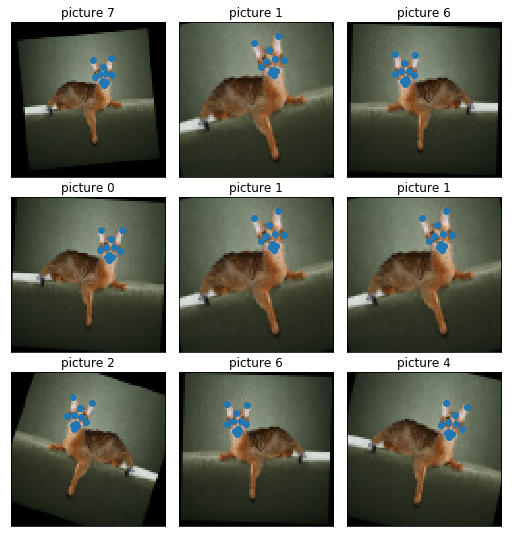

In [43]:
for a, b in generator(X[:1], y.iloc[:1], 9):
    
    plot_labelled_sample(a, b, 80)
    
    break

In [44]:
model = MyModel()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

epochs = 50
batch_size = 64

hist = model.fit_generator(
                    generator(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, 
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=(X_val/255, y_val/80)
                   )

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
66/65 [==============================] - 73s 1s/step - loss: 0.0824 - val_loss: 20215.2472
Epoch 2/50
10/65 [===>..........................] - ETA: 57s - loss: 0.0348

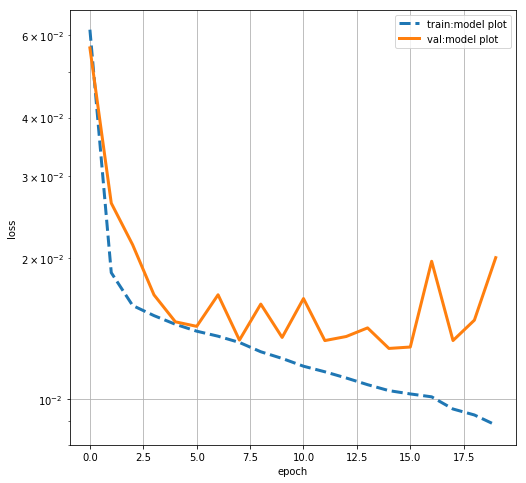

In [9]:
 def plot_loss(hist, name, plt, RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss)) * target_size/2 
        val_loss = np.sqrt(np.array(val_loss)) * target_size/2 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plt.figure(figsize=(8,8))
plot_loss(hist, "model plot", plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [10]:
model.load_weights('../models/my_model.h5')

In [11]:
def save_model(model, name):
    json_string = model.to_json()
    open("../models/"+name+'_architecture.json', 'w').write(json_string)
    model.save_weights("../models/"+name+'_weights.h5')
    model.save("../models/"+name+'_weights_and_all.h5')

def load_model(name):
    model = model_from_json(open("../models/"+name+'_architecture.json').read())
    model.load_weights("../models/"+name + '_weights.h5')
    model.compile(loss="mean_squared_error", optimizer=Adam())
    return model

In [12]:
model = load_model("my_model")
save_model(model, "my_model")

In [91]:
model.evaluate(X_test, y_test)

899/899 [==============================] - 5s 5ms/step


1449.2316477672675

In [14]:
y_pred = model.predict(X_test)

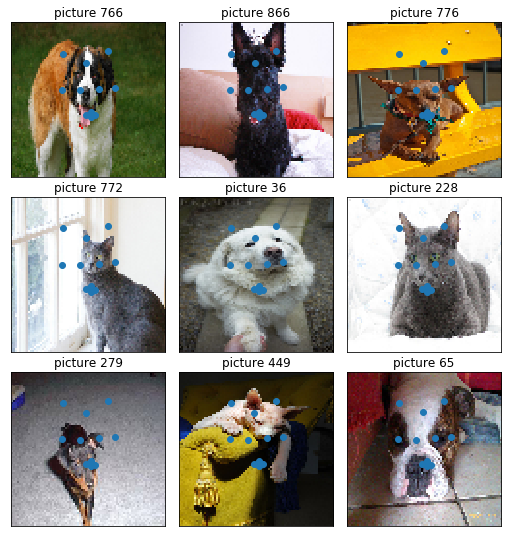

In [15]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_example(X_test[ipic], y_pred[ipic], ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [ ]:
# Weight decay in layers
######################################################################
# from keras import regularizers

# model = models.Sequential()
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# Callbacks like learning rate scheduling
######################################################################

# Tensorboard
######################################################################

# Pretrained Xception weights
######################################################################

In [ ]:
# import shutil
# from fastprogress import progress_bar
# y = load_coordinates_to_dataframe('../data/landmarks.csv')
# for filename in progress_bar(list(y.index)):
#     shutil.copyfile('../data/images/'+filename, '../data/labelled_images/'+filename)